In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn import tree, linear_model, ensemble
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from xgboost import XGBClassifier
from sklearn.svm import SVC
from scipy.stats import loguniform


## Read the dataset

In [3]:
data_df = pd.read_csv("credit-card-dataset/creditcard.csv")

In [4]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Check for any null values

In [5]:
[col for col in data_df.isna().any() if col == True]


[]

## Analyse the Dataset 

In [6]:
data_df.groupby("Class").mean()["Amount"] # Average amount transacted for each class

Class
0     88.291022
1    122.211321
Name: Amount, dtype: float64

### Defining Cost Matrix
We will define a cos matrix in order to quantify our models i.e. reduce the cost associated with each model. We need to define cost for False negative (Detecting valid transactions as Fraudulent) and false positive cases (Fraudulet transaction as valid). 
- For false positive cases, we are going to assign the average amount transacted in case of fraudulent transactions. 
- For False negative cases, we are going to assign a score of 20 on the basis of customer satisfaction rate, time to resolve the issue, etc.

In [7]:
cost_matrix = np.array([
    [10, -20], 
    [-122.211321, 100]
]).T


In [8]:
non_fraud = data_df[data_df["Class"] == 0]
fraud = data_df[data_df["Class"] == 1]

<AxesSubplot:xlabel='Time', ylabel='Amount'>

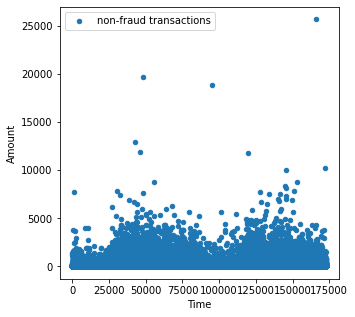

In [9]:
non_fraud.plot(label = "non-fraud transactions", kind = "scatter", y = "Amount", x = "Time", figsize = (5, 5))

<AxesSubplot:xlabel='Time', ylabel='Amount'>

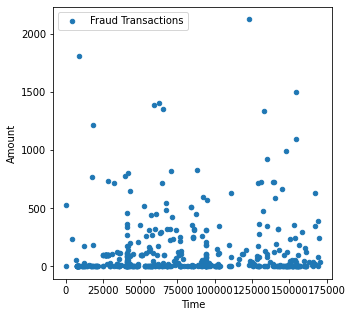

In [10]:
fraud.plot(label = "Fraud Transactions", kind = "scatter", y = "Amount", x = "Time", figsize = (5, 5))

In [11]:
data_df.drop('Time', axis=1, inplace=True)

### The dataset is highly imbalanced - The number of classes is biased towards non fraud as compared to fraud.

0    284315
1       492
Name: Class, dtype: int64


<AxesSubplot:title={'center':'Class Distribution'}>

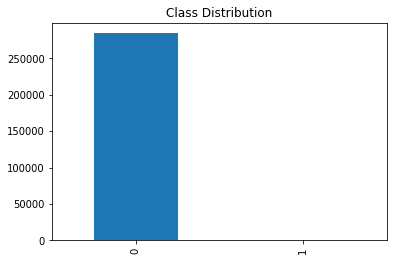

In [12]:
print(data_df['Class'].value_counts())
data_df['Class'].value_counts().plot(kind='bar', title="Class Distribution")

### Check for collinearity among the feature columns

Text(0.5, 1.0, 'Correlation Matrix')

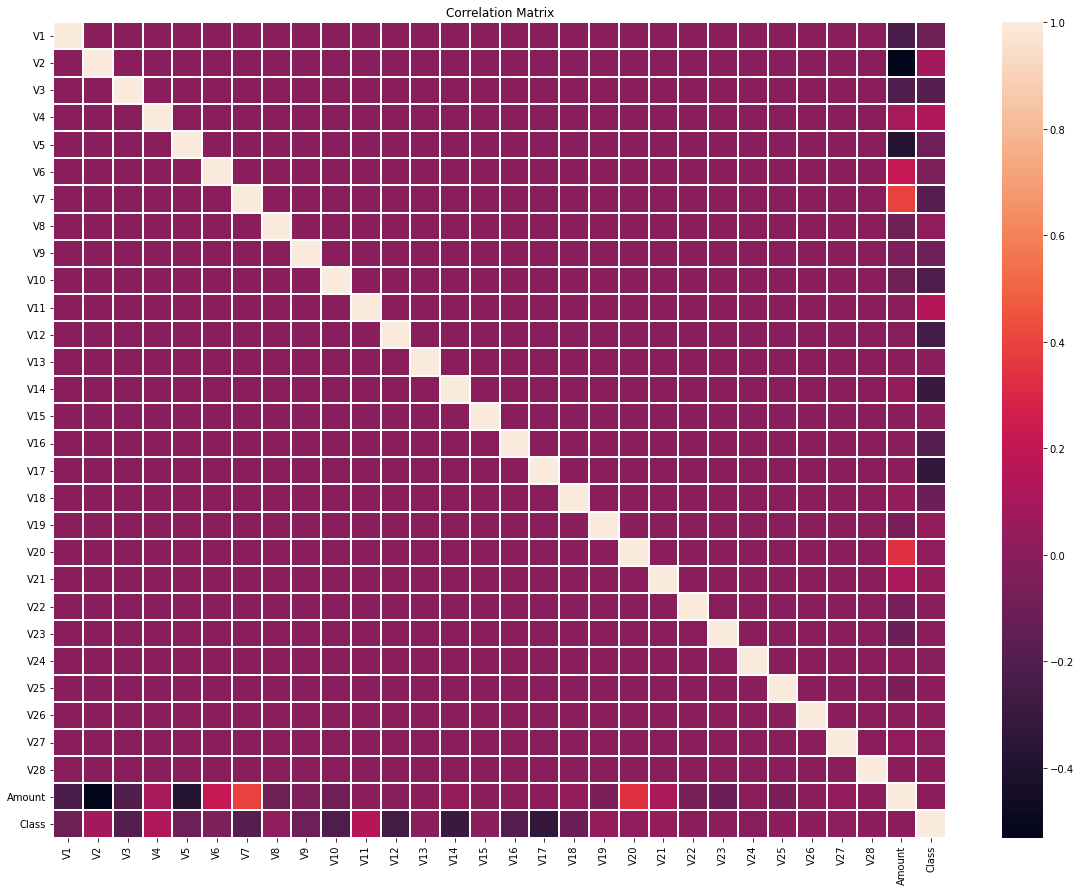

In [13]:
cor_mat = data_df.corr()
round(cor_mat)
plt.subplots(figsize=(20,15))
sns.heatmap(cor_mat, linewidths=2)
plt.title("Correlation Matrix")


As we can see above that there is not much collinearity among the independent variables hence, we don't need to drop any columns

In [14]:
df_X = data_df.drop("Class", axis = 1)
df_y = data_df["Class"]

## Dimension Reduction By Variable Selection

We are going to find most relevant features from the set of 28 columns using 3 different techniques (As dataset is imbalanced):-
- Random forest with weights 
- Random forest with oversampling
- Random forest with undersampling

In [15]:
rf_with_weights = SelectFromModel(RandomForestClassifier(n_estimators=100, class_weight='balanced'), max_features=10)
rf_with_weights.fit(df_X, df_y)

SelectFromModel(estimator=RandomForestClassifier(class_weight='balanced'),
                max_features=10)

In [16]:
rf_with_weights_cols = rf_with_weights.get_support()
rf_with_weights_feature = df_X.loc[:, rf_with_weights_cols].columns.tolist()

In [17]:
rf_with_weights_feature.append('Amount')
new_df = data_df[rf_with_weights_feature]
new_df.head()

,V3,V4,V7,V10,V11,V12,V14,V16,V17,Amount
0,2.536347,1.378155,0.239599,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,149.62
1,0.166480,0.448154,-0.078803,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,2.69
2,1.773209,0.379780,0.791461,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,378.66
3,1.792993,-0.863291,0.237609,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,123.50
4,1.548718,0.403034,0.592941,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,69.99


In [18]:
oversampler = SMOTE(random_state=42)
os_X, os_y = oversampler.fit_resample(df_X, df_y)
os_y.value_counts()

0    284315
1    284315
Name: Class, dtype: int64

In [19]:
rf_with_oversample = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=10)
rf_with_oversample.fit(os_X, os_y)

SelectFromModel(estimator=RandomForestClassifier(), max_features=10)

In [20]:
rf_with_oversample_cols = rf_with_oversample.get_support()
rf_with_oversample_features = df_X.loc[:, rf_with_oversample_cols].columns.tolist()

In [21]:
undersampler = ClusterCentroids(random_state=30)
us_X, us_y = undersampler.fit_resample(df_X, df_y)
us_y.value_counts()

0    492
1    492
Name: Class, dtype: int64

In [22]:
rf_with_undersampling = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=10)
rf_with_undersampling.fit(us_X, us_y)

SelectFromModel(estimator=RandomForestClassifier(), max_features=10)

In [23]:
rf_with_undersampling_cols = rf_with_undersampling.get_support()
rf_with_undersampling_features = df_X.loc[:, rf_with_undersampling_cols].columns.tolist()

In [24]:
all_cols = df_X.columns

In [25]:
feature_selector = pd.DataFrame({'feature_name': all_cols, 'rf_with_weights': rf_with_weights_cols, 'rf_with_oversample': rf_with_oversample_cols, 'rf_with_undersample': rf_with_undersampling_cols})

In [26]:
feature_selector['Total'] = np.sum(feature_selector, axis = 1)

# feature_selector[(feature_selector['rf_with_oversample'] == True) & (feature_selector['rf_with_weights'] == True)]

C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return reduction(axis=axis, out=out, **passkwargs)


Selecting the most relevant columns selected by all the 3 models

In [27]:
feature_selector

,feature_name,rf_with_weights,rf_with_oversample,rf_with_undersample,Total
0,V1,False,False,False,0
1,V2,False,False,False,0
2,V3,True,True,False,2
3,V4,True,True,False,2
4,V5,False,False,False,0
5,V6,False,False,False,0
6,V7,True,False,False,1
7,V8,False,False,False,0
8,V9,False,False,True,1
9,V10,True,True,True,3


In [28]:
important_features = list(feature_selector[feature_selector['Total'] >= 3]['feature_name'])

In [29]:
new_df = df_X.loc[:, important_features]

In [30]:
new_df.head()

,V10,V11,V12,V14,V17
0,0.090794,-0.551600,-0.617801,-0.311169,0.207971
1,-0.166974,1.612727,1.065235,-0.143772,-0.114805
2,0.207643,0.624501,0.066084,-0.165946,1.109969
3,-0.054952,-0.226487,0.178228,-0.287924,-0.684093
4,0.753074,-0.822843,0.538196,-1.119670,-0.237033


In [31]:
print(f"Count of rows = {len(new_df.index)} \nCount of columns = {len(new_df.columns)}")

Count of rows = 284807 
Count of columns = 5


In [32]:
new_df_X = new_df
new_df_y = df_y

In [33]:
new_df_y.value_counts()

0    284315
1       492
Name: Class, dtype: int64

Create a model evaluation dataframe to store all the models summary.

In [34]:
model_evaluation_df = pd.DataFrame(columns=["model", "recall", "accuracy"])

In [35]:
new_df = pd.concat([new_df_X, new_df_y], axis=1)

## Oversampling

We are gonna evaluate our model using two techniques to counter the **imbalance** in the dataset
- Oversample the minority class
- Undersample the majority class

In [36]:
os_new_df_X, os_new_df_y = oversampler.fit_resample(new_df_X, new_df_y)

In [37]:
os_new_df = pd.concat([os_new_df_X, os_new_df_y], axis = 1)

In [38]:
def do_stratified_distribution(os_new_df):
    '''Function to do Stratified distribution of train and test dataset
    '''
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in split.split(os_new_df, os_new_df["Class"]):
        os_train = os_new_df.loc[train_idx]
        os_test = os_new_df.loc[test_idx]
    
    # create train DF
    os_train_X = os_train.drop('Class', axis = 1)
    os_train_Y = os_train['Class']

    # create test Dataframe
    os_test_X = os_test.drop('Class', axis = 1)
    os_test_Y = os_test['Class']
    return os_train_X, os_train_Y, os_test_X, os_test_Y

In [39]:
new_df_train_X, new_df_train_y, new_df_test_X, new_df_test_y = do_stratified_distribution(new_df)

Create the train and test samples using stratified distribution

In [40]:
sampled_os_train_X, sampled_os_train_y, sampled_os_test_X, sampled_os_test_y = do_stratified_distribution(os_new_df)

Checking the distribution of classes after oversampling and stratified distribution

<AxesSubplot:>

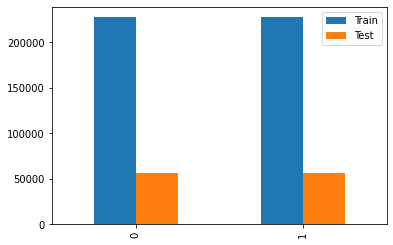

In [41]:
pd.concat({
    'Train': sampled_os_train_y.value_counts(), 'Test': sampled_os_test_y.value_counts()
}, axis=1).plot.bar()

In [42]:
def standard_confusion_matrix(y_true, y_pred):
    '''
    Reformat confusion matrix output from sklearn for plotting profit curve.
    '''
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def plot_roc(fpr_list, tpr_list, roc_auc_list, color_list, classifier_list):
    '''Plotting the roc/auc curve for specific models
    '''
    plt.figure(figsize=(7.5,7.5))
    lw = 2
    for fpr, tpr, roc_auc, color, classifier in zip(fpr_list, tpr_list, roc_auc_list, color_list, classifier_list):
        plt.plot(
            fpr,
            tpr,
            color=color,
            lw=lw,
            label=f"ROC curve for {classifier} (area = {round(roc_auc, 2)})",
        )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

def plot_profit_curve(model_list, cost_matrix, y_proba_list, y_test):
    '''
    Plot profit curve.

    INPUTS:
    - model object
    - cost benefit matrix in the same format as the confusion matrix above
    - predicted probabilities
    - actual labels
    '''

    # Profit curve data
    for model, y_proba in zip(model_list, y_proba_list):
        profits = [] # one profit value for each T (threshold)
        thresholds = sorted(y_proba, reverse=True)

    # For each threshold, calculate profit - starting with largest threshold
        for T in thresholds:
            y_pred = (y_proba > T).astype(int)
            confusion_matrix = standard_confusion_matrix(y_test, y_pred)
            # Calculate total profit for this threshold
            profit = sum(sum(confusion_matrix * cost_matrix)) / len(y_test)
            profits.append(profit)

    # Profit curve plot
    # for model in model_list:
        model_name = model
        max_profit = max(profits)
        print(f"{model_name}, max profit ${max_profit} per user")
        plt.plot(np.linspace(0, 1, len(y_test)), profits, label = f"{model_name}, max profit ${max_profit} per user")

def run_and_evaluate_model(model, model_name, X_train, Y_train, X_test, Y_test):
    global model_evaluation_df
    
    model.fit(X_train, Y_train)

    # Run stratified K fold validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    k_fold_scores = cross_val_score(estimator = model, X = X_train, y = Y_train, cv = cv)
    print("K fold cross validated scores = ")
    print(k_fold_scores)

    # Testing Scores cross validation
    y_pred = cross_val_predict(estimator = model, X = X_test, y = Y_test, cv = 10)
    
    y_score = model.predict_proba(X_test)

    y_proba = model.predict_proba(X_test)[:, 1]
    # print(y_score)
    # Prediction comparison
    accuracy = accuracy_score(Y_test, y_pred)
    print(f"Accuracy of the model = {accuracy}")

    # Confusion Matrix
    cm = confusion_matrix(Y_test, y_pred)
    cm = pd.DataFrame(cm, columns=np.unique(Y_test), index = np.unique(Y_test))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    plt.figure(figsize = (5,3))
    sns.heatmap(cm, fmt='g', annot=True)
    print(classification_report(Y_test, y_pred))
    plt.title(f"Confusion Matrix for {model_name}")
    # print classification report
    
    # Get recall score
    recall = recall_score(Y_test, y_pred)
    
    model_evaluation = pd.DataFrame({"model": model_name, "recall": recall , "accuracy": accuracy}, index=[0])
    model_evaluation_df = model_evaluation_df.append(model_evaluation)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(Y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # fpr["micro"], tpr, _ = roc_curve(Y_test.ravel(), y_pred.ravel())
    # roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc, y_proba


In [43]:
fpr_list, tpr_list, roc_auc_list, color_list, classifier_list, y_proba_list = [list() for i in range(6)]

# Model Evaluation

We are going to evaluate our classifers uing 6 different models -
- Logistic Regression without the preprocessing steps
- Random Forest
- Decision Tree
- Logistic Regression
- Gradient Boosting 
- XGBoost

### Logistic Regression without preprocessing steps

We are going to do a randomized grid search to find the best hyperparameters for our logistic regression model

In [44]:
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

In [45]:
model = linear_model.LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
logistic_search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)

In [46]:
logistic_search.fit(new_df_train_X, new_df_train_y)

C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.99915001        nan 0.99915001        nan 0.99915586 0.99915293
 0.99868624 0.99827075        nan        nan        nan        nan
 0.99915001        nan 0.99915001        nan        nan 0.99915001
 0.99827075        nan 0.99915001 0.99915293 0.99915001 0.99827075
 0.99915001        nan 0.99915001        nan 0.99915001 0.99915001
 0.99849898        nan 0.99915001        nan 0.99915001 0.99915001
        nan 0.99915001 0.9989525         nan 0.99915586 0.99915001
 0.99894665 0.99914708        nan 0.99850922        nan        nan
        nan        nan        nan 0.99915001        nan 0.99915001
        nan 0.99915001        nan        nan        nan        nan
 0.99915001        nan 0.99915001 0.99915147        nan 0.99908564
        nan 0.99915001 0.99915001 0.99827075        nan        nan
        nan        nan 0

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
                   estimator=LogisticRegression(), n_iter=500, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CC03560C40>,
                                        'penalty': ['none', 'l1', 'l2',
                                                    'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   random_state=1, scoring='accuracy')

Best Parameter for Logistic Regression

In [47]:
# Best Parameter for logistic regression
print(logistic_search.best_params_)

{'C': 0.15490420918251357, 'penalty': 'l2', 'solver': 'liblinear'}


In [48]:
def evaluate_best_params(model, test_X, test_y):
    predictions = model.predict(test_X)
    accuracy = accuracy_score(test_y, predictions)
    errors = abs(predictions - test_y)
    print(f"Average Error = {np.mean(errors)}")
    print(f"Average Accuracy = {accuracy}")
    cm = confusion_matrix(test_y, predictions)
    sns.heatmap(cm, annot=True)
    plt.title("Confusion Matrix")
    return recall_score(test_y, predictions)


Average Error = 0.0009655559846915488
Average Accuracy = 0.9990344440153085


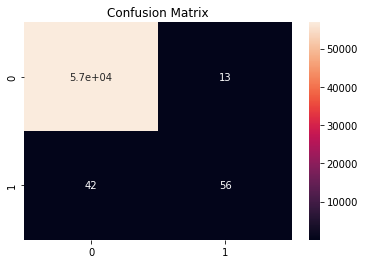

In [49]:
base_model = linear_model.LogisticRegression()
base_model.fit(new_df_train_X, new_df_train_y)
base_accuracy = evaluate_best_params(base_model, new_df_test_X, new_df_test_y)


In [50]:
base_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Average Error = 0.0009655559846915488
Average Accuracy = 0.9990344440153085


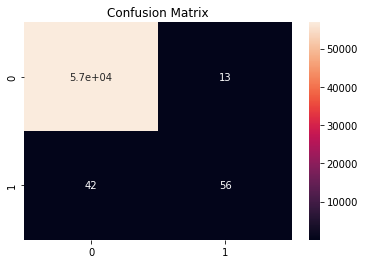

In [51]:
best_cv_model = logistic_search.best_estimator_
best_cv_accuracy = evaluate_best_params(best_cv_model, new_df_test_X, new_df_test_y)

In [52]:
model_evaluation = pd.DataFrame({"model": "Logistic Regression without Preprocessing", "recall": best_cv_accuracy , "accuracy": None}, index=[0])
model_evaluation_df = model_evaluation_df.append(model_evaluation)

In [53]:
best_cv_model.get_params()

{'C': 0.15490420918251357,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Random Forest

K fold cross validated scores = 
[0.99898881 0.99903278 0.99881295 0.99898881 0.99920862 0.99868103
 0.99883491 0.99879094 0.99876896 0.99920862 0.99896683 0.99881295
 0.9988789  0.99912071 0.99914267 0.99890086 0.99885689 0.99872499
 0.99881293 0.99901077 0.99890088 0.99892286 0.99892286 0.99890088
 0.99903275 0.99868103 0.99872499 0.99887887 0.99907672 0.9990987 ]
Accuracy of the model = 0.9943900251481631
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     56863
           1       1.00      0.99      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726



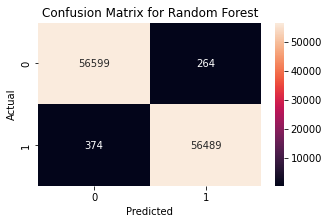

In [54]:
rf_model = RandomForestClassifier(n_estimators=100)
fpr, tpr, roc_auc, y_proba = run_and_evaluate_model(rf_model, "Random Forest", sampled_os_train_X, sampled_os_train_y, sampled_os_test_X, sampled_os_test_y)
fpr_list.append(fpr)
tpr_list.append(tpr)
roc_auc_list.append(roc_auc)
y_proba_list.append(y_proba)
classifier_list.append("random-forest")
color_list.append("blue")

### Logistic regression

K fold cross validated scores = 
[0.9296784  0.92945857 0.92899694 0.92796377 0.93046823 0.92943504
 0.92659925 0.92954495 0.92947901 0.92837986 0.92884307 0.92941461
 0.92774395 0.93060166 0.92932513 0.92965487 0.92772038 0.92967685
 0.92851176 0.92857771 0.92978831 0.92833747 0.92809567 0.92833747
 0.92822598 0.92943504 0.92866564 0.92811607 0.9312816  0.92978677]
Accuracy of the model = 0.9296906600073862
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     56863
           1       0.98      0.88      0.93     56863

    accuracy                           0.93    113726
   macro avg       0.93      0.93      0.93    113726
weighted avg       0.93      0.93      0.93    113726



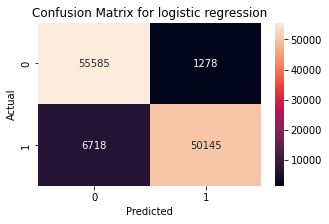

In [55]:
logit_regression = linear_model.LogisticRegression(C=0.15490420918251357, intercept_scaling=1, penalty = 'l2', solver = 'liblinear')
fpr, tpr, roc_auc, y_proba = run_and_evaluate_model(logit_regression, "logistic regression", sampled_os_train_X, sampled_os_train_y, sampled_os_test_X, sampled_os_test_y)
fpr_list.append(fpr)
tpr_list.append(tpr)
roc_auc_list.append(roc_auc)
y_proba_list.append(y_proba)
classifier_list.append("Logistic Regression")
color_list.append("red")

### Gradient Boosting

K fold cross validated scores = 
[0.95047372 0.9491328  0.94924271 0.94849531 0.94994504 0.94921961
 0.94649373 0.94761486 0.95012091 0.95009892 0.94886901 0.95023191
 0.94860522 0.94977028 0.94937349 0.95016487 0.94724115 0.94926357
 0.94838426 0.94860409 0.94849531 0.94904487 0.94992416 0.94847332
 0.9497472  0.94812047 0.94840624 0.94803253 0.94924159 0.94849417]
Accuracy of the model = 0.9505741870812303
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     56863
           1       0.98      0.92      0.95     56863

    accuracy                           0.95    113726
   macro avg       0.95      0.95      0.95    113726
weighted avg       0.95      0.95      0.95    113726



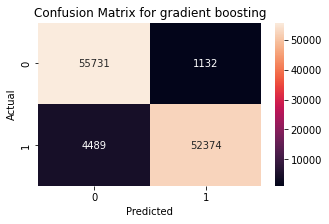

In [56]:
gb_clf = ensemble.GradientBoostingClassifier()
fpr, tpr, roc_auc, y_proba = run_and_evaluate_model(gb_clf, "gradient boosting", sampled_os_train_X, sampled_os_train_y, sampled_os_test_X, sampled_os_test_y)
fpr_list.append(fpr)
tpr_list.append(tpr)
roc_auc_list.append(roc_auc)
y_proba_list.append(y_proba)
classifier_list.append("Gradient Boosting")
color_list.append("violet")

### Decision Tree

K fold cross validated scores = 
[0.99608714 0.99558154 0.99520784 0.99527379 0.99597714 0.99494394
 0.99536162 0.99544955 0.99553748 0.99604309 0.9953837  0.99516388
 0.99529577 0.99566947 0.99520774 0.99547153 0.99558145 0.99577929
 0.99529567 0.99529567 0.99619705 0.99558154 0.99553758 0.99558154
 0.99575731 0.99542757 0.99531765 0.99529567 0.99531765 0.99621895]
Accuracy of the model = 0.9872412640908851
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     56863
           1       0.98      0.99      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726



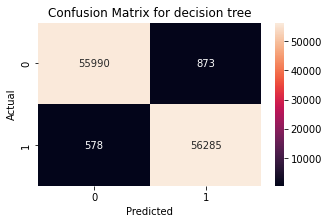

In [57]:
tree_model = tree.DecisionTreeClassifier()
fpr, tpr, roc_auc, y_proba = run_and_evaluate_model(tree_model, "decision tree", sampled_os_train_X, sampled_os_train_y, sampled_os_test_X, sampled_os_test_y)
fpr_list.append(fpr)
tpr_list.append(tpr)
roc_auc_list.append(roc_auc)
y_proba_list.append(y_proba)
classifier_list.append("Decision Tree")
color_list.append("Brown")

### XGBoost Classifier

C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:56:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:56:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:56:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:57:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:57:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:57:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:58:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:58:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:59:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:59:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:59:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:00:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:00:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:01:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:01:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:02:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:02:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:02:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:03:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:03:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:04:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:04:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:04:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:05:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:05:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
K fold cross validated scores = 
[0.99037172 0.99191049 0.99188851 0.99140489 0.99210816 0.99052539
 0.99092108 0.9916685  0.99107496 0.99067927 0.99133895 0.99008595
 0.99160273 0.99272384 0.99197626 0.99226204 0.99147065 0.99136074
 0.99149264 0.99061332 0.99100921 0.99158075 0.99171265 0.99085533
 0.99085513 0.9907672  0.99127281 0.99147065 0.99210816 0.99241592]
[23:06:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:07:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:07:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:07:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:07:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:07:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of the model = 0.9882964317746162
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56863
           1       0.99      0.99      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726



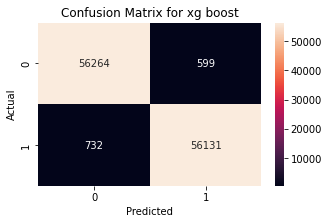

In [58]:
xgb_model = XGBClassifier()
fpr, tpr, roc_auc, y_proba = run_and_evaluate_model(xgb_model, "xg boost", sampled_os_train_X, sampled_os_train_y, sampled_os_test_X, sampled_os_test_y)
fpr_list.append(fpr)
tpr_list.append(tpr)
roc_auc_list.append(roc_auc)
y_proba_list.append(y_proba)
classifier_list.append("XG Boost")
color_list.append("Green")

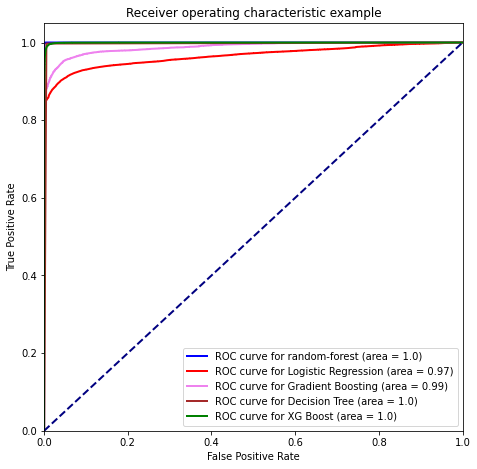

In [59]:
plot_roc(fpr_list, tpr_list, roc_auc_list, color_list, classifier_list)

### Profit Curve Analysis

random-forest, max profit $54.94879649495278 per user
Logistic Regression, max profit $52.51241019860014 per user
Gradient Boosting, max profit $52.703229841566575 per user
Decision Tree, max profit $54.46998840919403 per user
XG Boost, max profit $54.47331597038496 per user


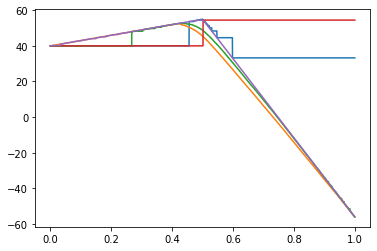

In [ ]:
plot_profit_curve(classifier_list, cost_matrix, y_proba_list, sampled_os_test_y)

## PCA for dimension reduction

In [74]:
pca=PCA()  
pca.n_components = len(df_X.columns)
pca_analysis = pca.fit(df_X)

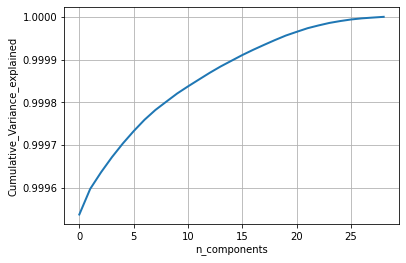

In [75]:
percentage_var_explained = pca.explained_variance_ratio_;  
cum_var_explained=np.cumsum(percentage_var_explained)
#plot PCA spectrum   
plt.figure(1,figsize=(6,4))
plt.clf()  
plt.plot(cum_var_explained,linewidth=2)  
plt.axis('tight')  
plt.grid() 
plt.xlabel('n_components') 
plt.ylabel('Cumulative_Variance_explained')  
plt.show()

## Undersampling

In [62]:


us_new_df_X, us_new_df_y = undersampler.fit_resample(new_df_X, new_df_y)

In [63]:
us_new_df = pd.concat([us_new_df_X, us_new_df_y], axis = 1)

In [64]:
sampled_us_train_X, sampled_us_train_y, sampled_us_test_X, sampled_us_test_y = do_stratified_distribution(us_new_df)

<AxesSubplot:>

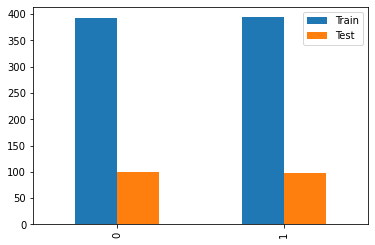

In [65]:
pd.concat({
    'Train': sampled_us_train_y.value_counts(), 'Test': sampled_us_test_y.value_counts()
}, axis=1).plot.bar()

In [66]:
fpr_list_us, tpr_list_us, roc_auc_list_us, color_list_us, classifier_list_us, y_proba_list_us = [list() for i in range(6)]

## Random Forest

K fold cross validated scores = 
[0.89873418 0.89873418 0.88607595 0.93670886 0.86075949 0.86075949
 0.89873418 0.94871795 0.88461538 0.8974359  0.92405063 0.92405063
 0.88607595 0.94936709 0.94936709 0.88607595 0.87341772 0.84615385
 0.8974359  0.92307692 0.92405063 0.88607595 0.84810127 0.86075949
 0.91139241 0.91139241 0.7721519  0.94871795 0.88461538 0.96153846]
Accuracy of the model = 0.9137055837563451
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        99
           1       0.94      0.89      0.91        98

    accuracy                           0.91       197
   macro avg       0.91      0.91      0.91       197
weighted avg       0.91      0.91      0.91       197



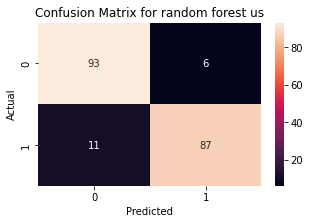

In [67]:
rf_model = RandomForestClassifier(n_estimators=100)
fpr, tpr, roc_auc, y_proba = run_and_evaluate_model(rf_model, "random forest us", sampled_us_train_X, sampled_us_train_y, sampled_us_test_X, sampled_us_test_y)
fpr_list_us.append(fpr)
tpr_list_us.append(tpr)
roc_auc_list_us.append(roc_auc)
classifier_list_us.append("random-forest")
color_list_us.append("blue")
y_proba_list_us.append(y_proba)

### Logistic Regression

K fold cross validated scores = 
[0.89873418 0.88607595 0.87341772 0.94936709 0.88607595 0.86075949
 0.91139241 0.97435897 0.88461538 0.93589744 0.93670886 0.91139241
 0.88607595 0.94936709 0.96202532 0.87341772 0.88607595 0.87179487
 0.88461538 0.91025641 0.93670886 0.91139241 0.86075949 0.87341772
 0.91139241 0.92405063 0.78481013 0.94871795 0.8974359  0.93589744]
Accuracy of the model = 0.9238578680203046
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        99
           1       0.96      0.89      0.92        98

    accuracy                           0.92       197
   macro avg       0.93      0.92      0.92       197
weighted avg       0.93      0.92      0.92       197



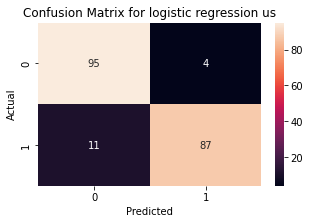

In [68]:
logit_regression = linear_model.LogisticRegression(penalty='l2')
fpr, tpr, roc_auc, y_proba = run_and_evaluate_model(logit_regression, "logistic regression us", sampled_us_train_X, sampled_us_train_y, sampled_us_test_X, sampled_us_test_y)
fpr_list_us.append(fpr)
tpr_list_us.append(tpr)
roc_auc_list_us.append(roc_auc)
y_proba_list_us.append(y_proba)
classifier_list_us.append("Logistic Regression")
color_list_us.append("red")

### Gradient Boosting

K fold cross validated scores = 
[0.87341772 0.88607595 0.88607595 0.91139241 0.87341772 0.91139241
 0.88607595 0.93589744 0.8974359  0.92307692 0.94936709 0.91139241
 0.84810127 0.94936709 0.93670886 0.86075949 0.89873418 0.85897436
 0.88461538 0.8974359  0.89873418 0.89873418 0.84810127 0.88607595
 0.91139241 0.91139241 0.7721519  0.94871795 0.87179487 0.93589744]
Accuracy of the model = 0.8883248730964467
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        99
           1       0.90      0.88      0.89        98

    accuracy                           0.89       197
   macro avg       0.89      0.89      0.89       197
weighted avg       0.89      0.89      0.89       197



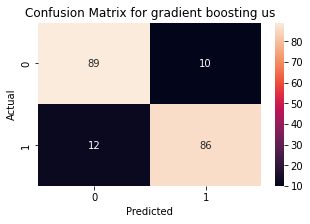

In [69]:
gb_clf = ensemble.GradientBoostingClassifier()
fpr, tpr, roc_auc, y_proba = run_and_evaluate_model(gb_clf, "gradient boosting us", sampled_us_train_X, sampled_us_train_y, sampled_us_test_X, sampled_us_test_y)
fpr_list_us.append(fpr)
tpr_list_us.append(tpr)
roc_auc_list_us.append(roc_auc)
classifier_list_us.append("Gradient Boosting")
color_list_us.append("violet")
y_proba_list_us.append(y_proba)

### Decision Tree

K fold cross validated scores = 
[0.86075949 0.83544304 0.86075949 0.89873418 0.86075949 0.82278481
 0.88607595 0.91025641 0.83333333 0.91025641 0.86075949 0.86075949
 0.81012658 0.91139241 0.83544304 0.81012658 0.84810127 0.80769231
 0.83333333 0.80769231 0.83544304 0.83544304 0.82278481 0.79746835
 0.88607595 0.84810127 0.74683544 0.93589744 0.79487179 0.8974359 ]
Accuracy of the model = 0.8426395939086294
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        99
           1       0.82      0.88      0.85        98

    accuracy                           0.84       197
   macro avg       0.84      0.84      0.84       197
weighted avg       0.84      0.84      0.84       197



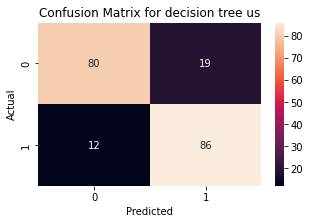

In [70]:
tree_model = tree.DecisionTreeClassifier()
fpr, tpr, roc_auc, y_proba = run_and_evaluate_model(tree_model, "decision tree us", sampled_us_train_X, sampled_us_train_y, sampled_us_test_X, sampled_us_test_y)
fpr_list_us.append(fpr)
tpr_list_us.append(tpr)
roc_auc_list_us.append(roc_auc)
classifier_list_us.append("Decision Tree")
color_list_us.append("Brown")
y_proba_list_us.append(y_proba)

### XG Boost

C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Progr

[23:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Progr

[23:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Progr

[23:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Progr

[23:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Progr

[23:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Progr

[23:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Progr

[23:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Progr

[23:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Progr

[23:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
K fold cross validated scores = 
[0.86075949 0.88607595 0.87341772 0.92405063 0.86075949 0.87341772
 0.88607595 0.93589744 0.87179487 0.91025641 0.94936709 0.91139241
 0.86075949 0.92405063 0.93670886 0.83544304 0.88607595 0.84615385
 0.91025641 0.92307692 0.88607595 0.87341772 0.83544304 0.86075949
 0.89873418 0.89873418 0.78481013 0.97435897 0.87179487 0.92307692]
[23:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:03] 

C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Progr

[23:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Progr

[23:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\akash\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of the model = 0.9086294416243654
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        99
           1       0.93      0.88      0.91        98

    accuracy                           0.91       197
   macro avg       0.91      0.91      0.91       197
weighted avg       0.91      0.91      0.91       197



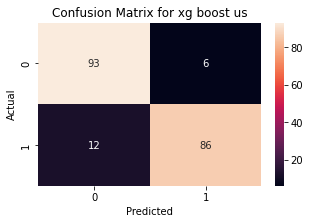

In [71]:
xgb_model = XGBClassifier()
fpr, tpr, roc_auc, y_proba = run_and_evaluate_model(xgb_model, "xg boost us", sampled_us_train_X, sampled_us_train_y, sampled_us_test_X, sampled_us_test_y)
fpr_list_us.append(fpr)
tpr_list_us.append(tpr)
roc_auc_list_us.append(roc_auc)
y_proba_list_us.append(y_proba)
classifier_list_us.append("XG Boost")
color_list_us.append("Green")

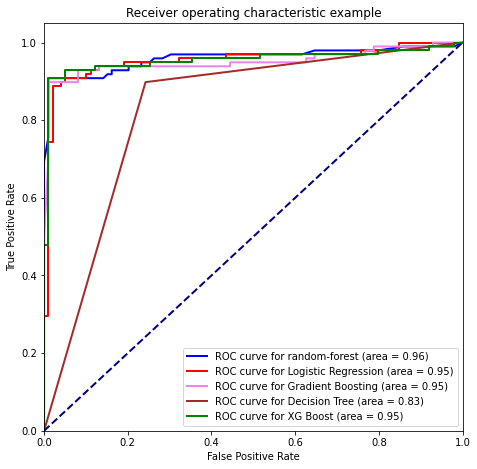

In [72]:
plot_roc(fpr_list_us, tpr_list_us, roc_auc_list_us, color_list_us, classifier_list_us)

random-forest, max profit $53.24873096446701 per user
Logistic Regression, max profit $53.70558375634518 per user
Gradient Boosting, max profit $53.857868020304565 per user
Decision Tree, max profit $40.30456852791878 per user
XG Boost, max profit $54.01015228426396 per user


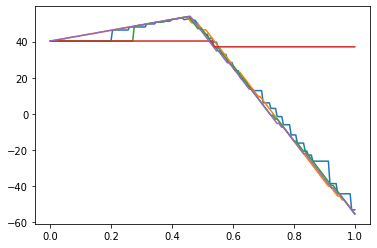

In [63]:
plot_profit_curve(classifier_list_us, cost_matrix, y_proba_list_us, sampled_us_test_y)

In [76]:
model_evaluation_df.sort_values(by = ["recall", "accuracy"], ascending=False)

,model,recall,accuracy
0,Random Forest,0.993423,0.994390
0,decision tree,0.989835,0.987241
0,xg boost,0.987127,0.988296
0,gradient boosting,0.921056,0.950574
0,logistic regression us,0.887755,0.923858
0,random forest us,0.887755,0.913706
0,logistic regression,0.881856,0.929691
0,xg boost us,0.877551,0.908629
0,gradient boosting us,0.877551,0.888325
0,decision tree us,0.877551,0.842640
